In [1]:
%load_ext autoreload
%autoreload 2
import sys
if ".." not in sys.path:
    sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
import json
from signatures.tensor_algebra import TensorAlgebra
from signatures.tensor_sequence import TensorSequence
from signatures.stationary_signature import stationary_signature_from_path
from signatures.expected_signature import expected_signature, expected_stationary_signature
from scipy.optimize import minimize

In [2]:
%%time
ta = TensorAlgebra(dim=2)

Compiling...
Compilation finished.
CPU times: user 2min 31s, sys: 266 ms, total: 2min 31s
Wall time: 2min 32s


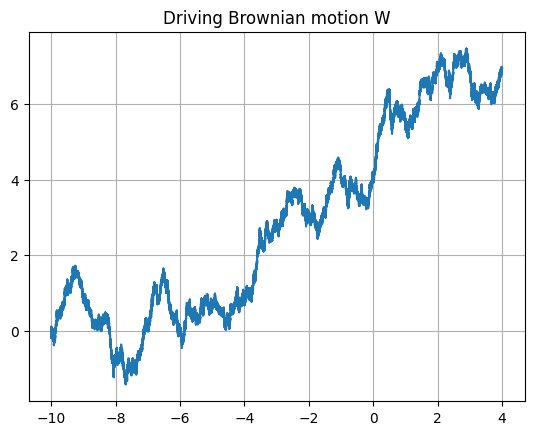

In [3]:
points_per_day = 3000 # 4 sec sampling frequency
T = 4

t_grid = np.linspace(-10, T, points_per_day * T * 365 * 24 + 1)

rng = np.random.default_rng(seed=42)
W = np.concatenate([[0], np.cumsum(rng.normal(size=len(t_grid) - 1) * np.sqrt(np.diff(t_grid)))])

fig, ax = plt.subplots()

ax.plot(t_grid, W)
ax.set_title("Driving Brownian motion W")
ax.grid()

## OU case: $d\sigma_t = \kappa (\theta - \sigma_t) dt + \nu dW_t$

In [4]:
kappa = 5
theta = 0.2
nu = 0.5

vol_inst = np.zeros_like(W)
vol_inst[0] = theta
dt = np.diff(t_grid)
dW = np.diff(W)
for i in range(vol_inst.size - 1):
    vol_inst[i + 1] = vol_inst[i] + kappa * (theta - vol_inst[i]) * dt[i] + nu * dW[i]

X = np.concatenate([[0], np.cumsum(-0.5 * vol_inst[:-1]**2 * np.diff(t_grid) + vol_inst[:-1] * np.diff(W))])
S = np.exp(X)

Text(0.5, 1.0, 'Instantaneous volatility')

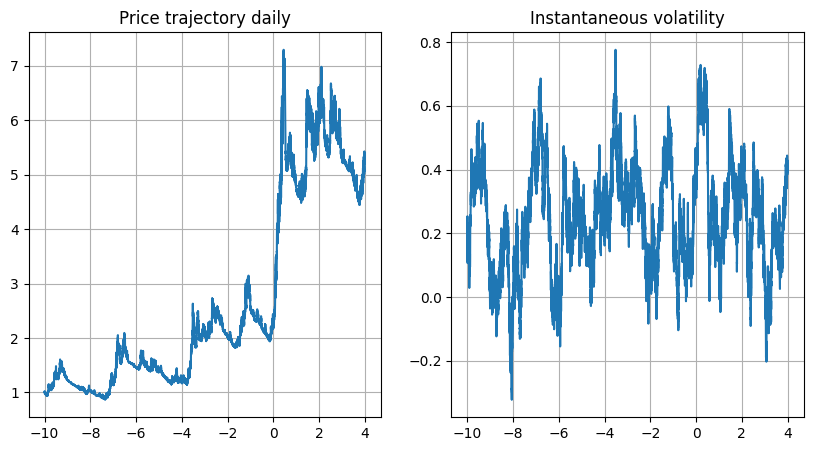

In [5]:
t_daily = t_grid[::points_per_day]
S_daily = S[::points_per_day]
X_daily = X[::points_per_day]
W_daily = W[::points_per_day]
vol_daily = vol_inst[::points_per_day]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(t_daily, S_daily)
ax[0].grid()
ax[0].set_title("Price trajectory daily")

ax[1].plot(t_daily, vol_inst[::points_per_day])
ax[1].grid()
ax[1].set_title("Instantaneous volatility")

In [6]:
path = np.vstack([t_daily, W_daily]).T
path_pos = np.vstack([t_daily[t_daily >= 0], W_daily[t_daily >= 0]]).T
N = 10
W_sig = ta.path_to_sequence(path=path_pos, trunc=N)

In [7]:
N = 10
lam = 10
SigS = stationary_signature_from_path(path=path, trunc=N, t_grid=t_daily, lam=lam)

In [8]:
Ø = ta.from_dict({"": 1}, trunc=N)
_1 = ta.from_dict({"1": 1}, trunc=N)
_2 = ta.from_dict({"2": 1}, trunc=N)
_11 = ta.from_dict({"11": 1}, trunc=N)
_12 = ta.from_dict({"12": 1}, trunc=N)
_21 = ta.from_dict({"21": 1}, trunc=N)
_22 = ta.from_dict({"22": 1}, trunc=N)
_221 = ta.from_dict({"221": 1}, trunc=N)

### Regression of vol

In [9]:
trunc = 5
n_params = 2**(trunc + 1) - 1
eps_sig = 1e-5
eps_sigs = 0
t_daily_pos = t_daily[t_daily >= 0]
vol_daily_pos = vol_daily[t_daily >= 0]

in_sample_T = 1

in_sample_idx = (t_daily_pos <= in_sample_T)

Y = vol_daily_pos + 50 * vol_daily_pos**3 + 30 * vol_daily_pos**4 + 100 * vol_daily_pos**5

def loss_vol_sig(l):
    vol_coef = ta.from_array(array=l, trunc=trunc*2 + 1)
    return np.mean((Y - np.real(W_sig @ vol_coef).squeeze())[in_sample_idx]**2) + eps_sig * np.sum(np.abs(l))

def loss_vol_stat_sig(l):
    vol_coef = ta.from_array(array=l, trunc=trunc*2 + 1)
    return np.mean((Y - np.real(SigS @ vol_coef).squeeze())[in_sample_idx]**2) + eps_sigs * np.sum(np.abs(l))

In [10]:
l0 = np.zeros(n_params)
res = minimize(fun=loss_vol_sig, x0=l0)

In [11]:
res_stat = minimize(fun=loss_vol_stat_sig, x0=l0)

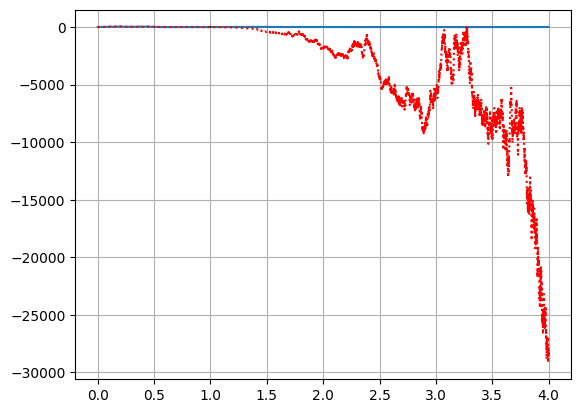

In [12]:
l_reg = ta.from_array(array=res.x, trunc=trunc*2 + 1)

fig, ax = plt.subplots()
ax.plot(t_daily_pos, Y)
ax.plot(t_daily_pos, (W_sig @ l_reg).real, "r:")
ax.vlines(x=in_sample_T, ymin=np.min(Y), ymax=np.max(Y), color="k")
ax.grid()

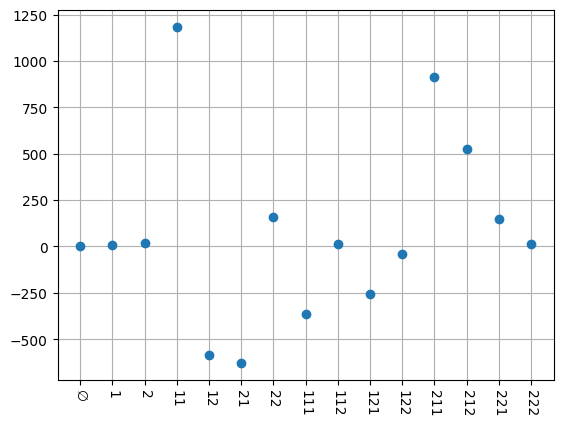

In [13]:
ta.plot_coefficients(l_reg, trunc=3)

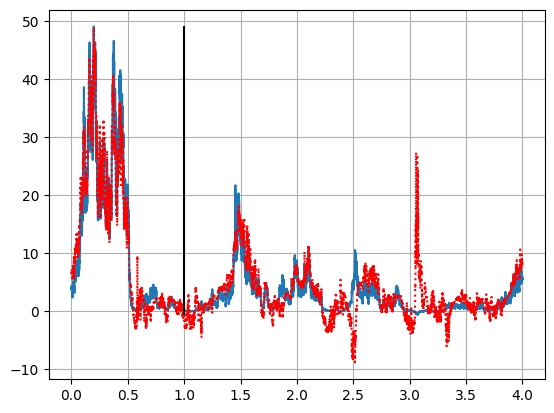

In [14]:
l_reg_stat = ta.from_array(array=res_stat.x, trunc=trunc*2 + 1)

fig, ax = plt.subplots()
ax.plot(t_daily_pos, Y)
ax.plot(t_daily_pos, (SigS @ l_reg_stat).real, "r:")
ax.vlines(x=in_sample_T, ymin=np.min(Y), ymax=np.max(Y), color="k")
ax.grid()

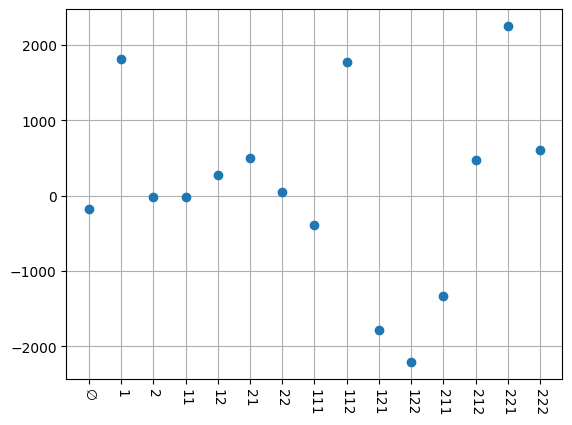

In [15]:
ta.plot_coefficients(l_reg_stat, trunc=3)

### Prediction of vol

In [31]:
%%time

dt = t_daily_pos[1] - t_daily_pos[0]
eSigS_dt = expected_stationary_signature(trunc=5, lam=lam, t=dt)

CPU times: user 20.4 s, sys: 55.6 ms, total: 20.4 s
Wall time: 20.5 s


In [32]:
from signatures.stationary_signature import discount_ts

# TODO: calculate pred signature as time-dependent signature

t_grid_pred = t_daily_pos[t_daily_pos > in_sample_T]

t0_idx = np.where(t_daily_pos <= in_sample_T)[0][-1]
t = t_daily_pos[t0_idx]
SigS_t = SigS[t0_idx]

signal_pred = np.zeros_like(t_grid_pred)
signal_pred_std = np.zeros_like(t_grid_pred)
l_reg_stat_sq = l_reg_stat.shuffle_pow(2)
for i in range(t_grid_pred.size):
    SigS_t.update(discount_ts(SigS_t, dt, lam).tensor_prod(eSigS_dt))
    signal_pred[i] = (SigS_t @ l_reg_stat).squeeze().real
    signal_pred_std[i] = np.sqrt((SigS_t @ l_reg_stat_sq).squeeze().real - signal_pred[i]**2)

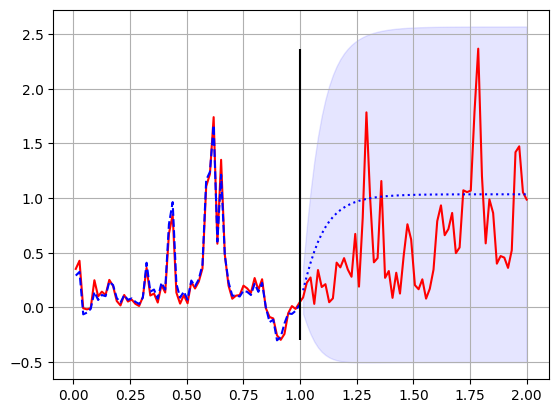

In [33]:
fig, ax = plt.subplots()
ax.plot(t_daily_pos, Y, "r")
ax.plot(t_daily_pos[t_daily_pos <= in_sample_T], (SigS @ l_reg_stat).real[t_daily_pos <= in_sample_T], "b--")
ax.plot(t_grid_pred, signal_pred, "b:")
ax.fill_between(t_grid_pred, signal_pred - signal_pred_std, signal_pred + signal_pred_std, color="b", alpha=0.1)
ax.vlines(x=in_sample_T, ymin=np.min(Y), ymax=np.max(Y), color="k")
ax.grid()

## Expected signature

In [131]:
N = 10
Ø = ta.from_dict({"": 1}, trunc=N)
_1 = ta.from_dict({"1": 1}, trunc=N)
_2 = ta.from_dict({"2": 1}, trunc=N)
_11 = ta.from_dict({"11": 1}, trunc=N)
_12 = ta.from_dict({"12": 1}, trunc=N)
_21 = ta.from_dict({"21": 1}, trunc=N)
_22 = ta.from_dict({"22": 1}, trunc=N)
_221 = ta.from_dict({"221": 1}, trunc=N)
_2222 = ta.from_dict({"2222": 1}, trunc=N)

In [132]:
lam = 10
T = 1000
n_grid = 10000
trunc = 5
dim = 2

T0 = -50
t_grid = np.unique(np.concatenate([np.linspace(T0, 0, n_grid), np.linspace(0, T, n_grid)]))

In [164]:
h = 0.1
eSigS = expected_stationary_signature(5, lam, h=0.1)

In [165]:
ta.print(eSigS)

1.0*∅ + 0.06321205588285578*1 + 0.001997822687527725*11 + 0.021616617919084688*22 + 4.208907972068608e-05*111 + 0.0007884302412366172*122 + 0.0005779553875812665*221 + 6.648917190024097e-07*1111 + 1.7718898979107375e-05*1122 + 1.4392860216144637e-05*1221 + 1.1067674499352085e-05*2211 + 0.00023363162264998123*2222 + 8.400211509370006e-09*11111 + 2.904192122228098e-07*11122 + 2.483818058457431e-07*11221 + 2.063523623633846e-07*12211 + 6.164300385528035e-06*12222 + 1.6433784608381954e-07*22111 + 4.711906927294072e-06*22122 + 3.889903903628455e-06*22221


In [103]:
rng = np.random.default_rng(seed=42)
W = np.concatenate([[0], np.cumsum(rng.normal(size=len(t_grid) - 1) * np.sqrt(np.diff(t_grid)))])
path = np.vstack([t_grid, W]).T

In [104]:
%%time

SigS = stationary_signature_from_path(path=path, trunc=trunc, t_grid=t_grid, lam=lam)

CPU times: user 14.8 s, sys: 20 ms, total: 14.8 s
Wall time: 14.8 s


In [105]:
ta.print(eSigS)

1.0*∅ + 0.1*1 + 0.005000000000000001*11 + 0.025*22 + 0.00016666666666666672*111 + 0.0016666666666666668*122 + 0.0008333333333333334*221 + 4.166666666666668e-06*1111 + 6.250000000000001e-05*1122 + 4.166666666666667e-05*1221 + 2.0833333333333336e-05*2211 + 0.00031250000000000006*2222 + 8.333333333333336e-08*11111 + 1.666666666666667e-06*11122 + 1.2500000000000005e-06*11221 + 8.333333333333335e-07*12211 + 1.666666666666667e-05*12222 + 4.1666666666666677e-07*22111 + 8.333333333333335e-06*22122 + 6.250000000000002e-06*22221


In [106]:
eSigS_emp = TensorSequence(SigS.alphabet, SigS.trunc, SigS.array.mean(axis=1), SigS.indices)

In [113]:
np.abs((eSigS_emp - eSigS).array).max()

0.006402087092370196